In [269]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = './input'
dirs = os.listdir(path)
for file in dirs:
    print(file)

sample_submission.csv
test.csv
train.csv


In [127]:
# Import Files
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

# Data Cleaning

In [128]:
train.head()

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,1,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,2,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,3,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,4,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,5,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000


In [5]:
train = train.drop(['id'], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Overall Qual    1350 non-null   int64 
 1   Gr Liv Area     1350 non-null   int64 
 2   Exter Qual      1350 non-null   object
 3   Garage Cars     1350 non-null   int64 
 4   Garage Area     1350 non-null   int64 
 5   Kitchen Qual    1350 non-null   object
 6   Total Bsmt SF   1350 non-null   int64 
 7   1st Flr SF      1350 non-null   int64 
 8   Bsmt Qual       1350 non-null   object
 9   Full Bath       1350 non-null   int64 
 10  Year Built      1350 non-null   int64 
 11  Year Remod/Add  1350 non-null   int64 
 12  Garage Yr Blt   1350 non-null   int64 
 13  target          1350 non-null   int64 
dtypes: int64(11), object(3)
memory usage: 147.8+ KB


- `id` : 데이터 고유 id
- `OverallQual` : 전반적 재료와 마감 품질
- `YearBuilt` : 완공 연도
- `YearRemodAdd` : 리모델링 연도
- `ExterQual` : 외관 재료 품질
- `BsmtQual` : 지하실 높이
- `TotalBsmtSF` : 지하실 면적
- `1stFlrSF` : 1층 면적
- `GrLivArea` : 지상층 생활 면적
- `FullBath` : 지상층 화장실 개수
- `KitchenQual` : 부억 품질
- `GarageYrBlt` : 차고 완공 연도
- `GarageCars`: 차고 자리 개수
- `GarageArea`: 차고 면적
- `target` : 집값(달러 단위)

In [12]:
train.isnull().sum()

Overall Qual      0
Gr Liv Area       0
Exter Qual        0
Garage Cars       0
Garage Area       0
Kitchen Qual      0
Total Bsmt SF     0
1st Flr SF        0
Bsmt Qual         0
Full Bath         0
Year Built        0
Year Remod/Add    0
Garage Yr Blt     0
target            0
dtype: int64

In [46]:
continuous_features = list(train.columns[train.dtypes=='int64'])
categorical_features = list(train.columns[train.dtypes=='object'])

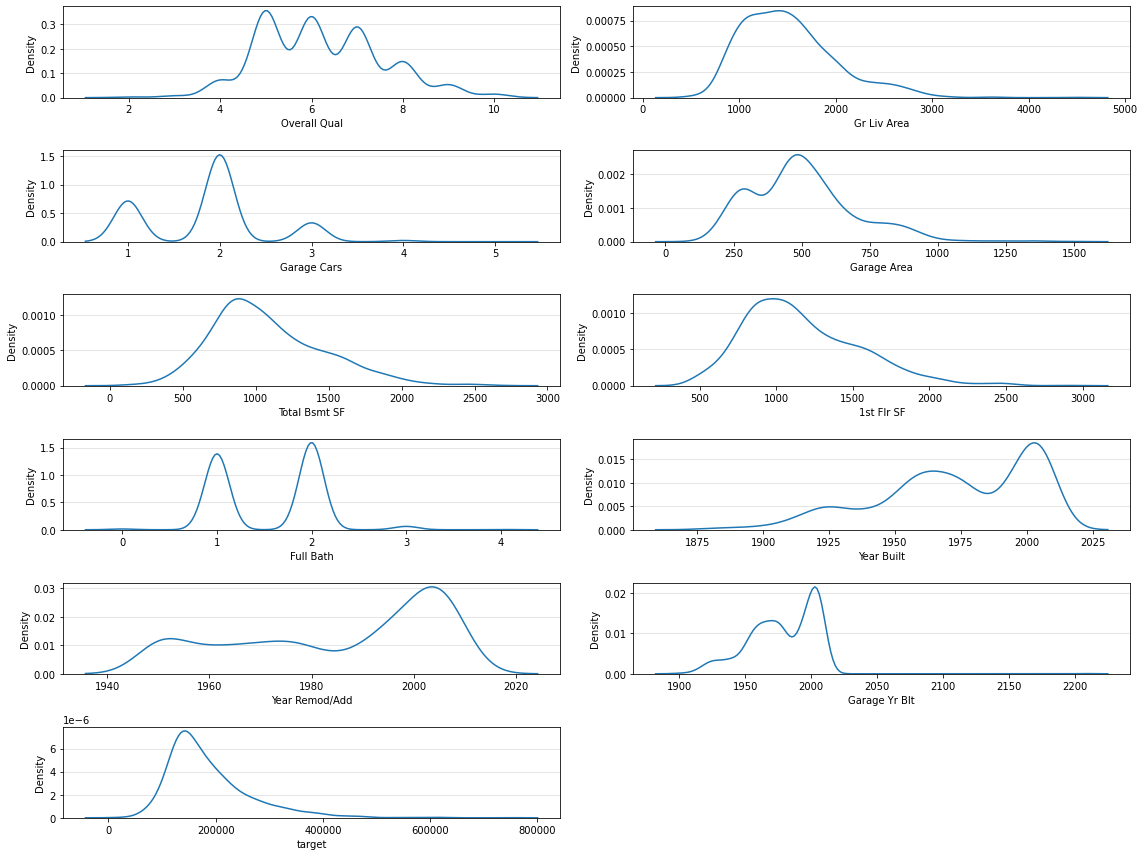

In [59]:
## Distribution of other continuous variables
plt.figure(figsize=(16,12))

for i, col in enumerate(continuous_features):
    ax = plt.subplot(6,2,i+1)
    sns.kdeplot(train[col])
    ax.grid(axis='y', linestyle='-', alpha=0.4)
    plt.tight_layout()

면적과 관련된 지표들 : 일관되게 좌측으로 치우쳐 있음
- `TotalBsmtSF`(지하실 면적) : 좌측으로 치우쳐 있음
- `1stFlrSF`(1층 면적) : 좌측으로 치우쳐 있음
- `GrLivArea`(지상층 생활 면적) : 좌측으로 치우쳐 있음
- `GarageArea`(차고 면적) : 좌측으로 치우쳐 있음

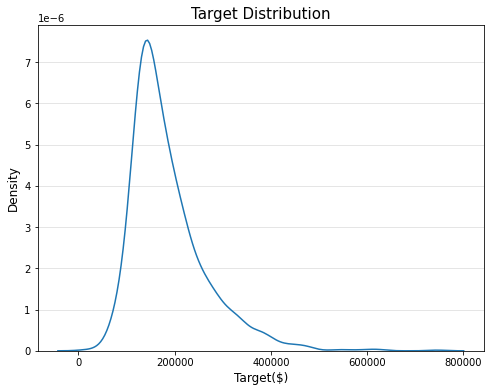

In [48]:
## Distribution of target variable
plt.figure(figsize=(8,6))
sns.kdeplot(train['target'])
plt.title('Target Distribution', fontsize=15)
plt.xlabel('Target($)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.4)

In [73]:
## Number of unique categories of categorical variables
for col in categorical_features:
    print('Number of unique categories of %s : %s'%(col, train[col].value_counts().nunique()))

Number of unique categories of Exter Qual : 4
Number of unique categories of Kitchen Qual : 4
Number of unique categories of Bsmt Qual : 5


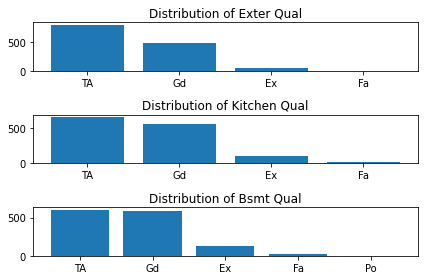

In [94]:
for i, col in enumerate(categorical_features):
    ax = plt.subplot(3, 1, i+1)
    plt.bar(list(train[col].value_counts().index), list(train[col].value_counts().values))
    plt.title('Distribution of %s'%col)
    plt.tight_layout()

- `TA` : Typical/Average
- `Gd` : Good
- `Ex` : Excellent
- `Fa` : Fair
- `Po` : Poor

Quality 를 나타내는 지표들은 보통~좋음 수준에 몰려있는 특징이 있다.

Quality 를 나타내는 지표들은 애초에 ordinal 한 특성을 가지고 있는 qualitative variable 이므로 one-hot encoding 대신에 label encoding 을 해 주어도 된다.

In [117]:
def label_encoder(data):
    le = LabelEncoder()
    le_count = 0
    for column in data:
        if data[column].dtype == 'object':
            le.fit(data[column])
            data[column] = le.transform(data[column])
            le_count += 1
    print('%d columns were label encoded'%le_count)
    return data

In [118]:
train_le = train.copy()
label_encoder(train_le)

3 columns were label encoded


,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,10,2392,0,3,968,0,2392,2392,0,2,2003,2003,2003,386250
1,7,1352,2,2,466,2,1352,1352,0,2,2006,2007,2006,194000
2,5,900,3,1,288,3,864,900,4,1,1967,1967,1967,123000
3,5,1174,3,2,576,2,680,680,4,1,1900,2006,2000,135000
4,7,1958,2,3,936,2,1026,1026,2,2,2005,2005,2005,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,6,1756,2,2,422,3,872,888,0,2,1996,1997,1996,204000
1346,9,2748,2,3,850,0,1850,1850,0,2,2006,2006,2006,390000
1347,5,1214,3,1,318,3,1214,1214,4,2,1967,1967,1967,143000
1348,5,894,3,2,440,3,864,894,2,1,1974,1974,1974,131000


In [119]:
train_le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Overall Qual    1350 non-null   int64
 1   Gr Liv Area     1350 non-null   int64
 2   Exter Qual      1350 non-null   int32
 3   Garage Cars     1350 non-null   int64
 4   Garage Area     1350 non-null   int64
 5   Kitchen Qual    1350 non-null   int32
 6   Total Bsmt SF   1350 non-null   int64
 7   1st Flr SF      1350 non-null   int64
 8   Bsmt Qual       1350 non-null   int32
 9   Full Bath       1350 non-null   int64
 10  Year Built      1350 non-null   int64
 11  Year Remod/Add  1350 non-null   int64
 12  Garage Yr Blt   1350 non-null   int64
 13  target          1350 non-null   int64
dtypes: int32(3), int64(11)
memory usage: 132.0 KB


In [125]:
def corr_heatmap(data):
    correlations = data[data.columns].corr()
    cmap = sns.diverging_palette(50, 10, as_cmap=True)
    plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidth=.5, annot=True, cbar_kws={'shrink': .75})
    plt.show()

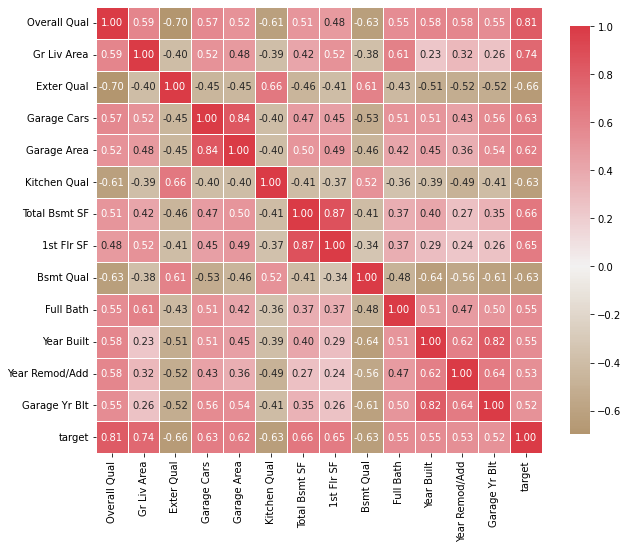

In [126]:
corr_heatmap(train_le)

`Target`이 가장 높은 상관을 보이는 변수는 `Overall Qual`로, 상관계수는 0.81이다.

# Feature Engineering

In [131]:
train = label_encoder(train)
train.info()

3 columns were label encoded
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Overall Qual    1350 non-null   int64
 1   Gr Liv Area     1350 non-null   int64
 2   Exter Qual      1350 non-null   int32
 3   Garage Cars     1350 non-null   int64
 4   Garage Area     1350 non-null   int64
 5   Kitchen Qual    1350 non-null   int32
 6   Total Bsmt SF   1350 non-null   int64
 7   1st Flr SF      1350 non-null   int64
 8   Bsmt Qual       1350 non-null   int32
 9   Full Bath       1350 non-null   int64
 10  Year Built      1350 non-null   int64
 11  Year Remod/Add  1350 non-null   int64
 12  Garage Yr Blt   1350 non-null   int64
 13  target          1350 non-null   int64
dtypes: int32(3), int64(11)
memory usage: 132.0 KB


## Polynomial features?

In [195]:
poly_cols = ['Overall Qual', 'Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Area']
poly_features = train[poly_cols]
poly_target = train['target']
print('Features shape :', poly_features.shape)
poly_transformer = PolynomialFeatures(degree=2)
poly_transformer.fit(poly_features)

Features shape : (1350, 5)


PolynomialFeatures()

In [196]:
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape :', poly_features.shape)

Polynomial Features shape : (1350, 21)


In [197]:
poly_transformer.get_feature_names(input_features=poly_cols)

['1',
 'Overall Qual',
 'Gr Liv Area',
 'Total Bsmt SF',
 '1st Flr SF',
 'Garage Area',
 'Overall Qual^2',
 'Overall Qual Gr Liv Area',
 'Overall Qual Total Bsmt SF',
 'Overall Qual 1st Flr SF',
 'Overall Qual Garage Area',
 'Gr Liv Area^2',
 'Gr Liv Area Total Bsmt SF',
 'Gr Liv Area 1st Flr SF',
 'Gr Liv Area Garage Area',
 'Total Bsmt SF^2',
 'Total Bsmt SF 1st Flr SF',
 'Total Bsmt SF Garage Area',
 '1st Flr SF^2',
 '1st Flr SF Garage Area',
 'Garage Area^2']

In [198]:
poly_features = pd.DataFrame(poly_features,
                             columns=poly_transformer.get_feature_names(poly_cols))
poly_features['target'] = poly_target

In [202]:
poly_features.corr()['target'].sort_values(ascending=False)

target                        1.000000
Overall Qual Gr Liv Area      0.882514
Gr Liv Area Total Bsmt SF     0.839661
Overall Qual 1st Flr SF       0.837815
Overall Qual^2                0.835420
Overall Qual Total Bsmt SF    0.835225
Overall Qual                  0.810607
Overall Qual Garage Area      0.810020
Gr Liv Area Garage Area       0.798808
Gr Liv Area 1st Flr SF        0.792860
Total Bsmt SF Garage Area     0.752124
1st Flr SF Garage Area        0.743703
Gr Liv Area                   0.742061
Gr Liv Area^2                 0.735727
Total Bsmt SF 1st Flr SF      0.692299
Total Bsmt SF^2               0.687473
Total Bsmt SF                 0.664047
1st Flr SF^2                  0.652441
1st Flr SF                    0.646843
Garage Area                   0.617151
Garage Area^2                 0.580069
1                                  NaN
Name: target, dtype: float64

`Target`과의 상관계수가 0.8을 넘는 변수들을 새로운 feature 들로 포함시킨다.

In [210]:
poly_features.corr()['target']

1                                  NaN
Overall Qual                  0.810607
Gr Liv Area                   0.742061
Total Bsmt SF                 0.664047
1st Flr SF                    0.646843
Garage Area                   0.617151
Overall Qual^2                0.835420
Overall Qual Gr Liv Area      0.882514
Overall Qual Total Bsmt SF    0.835225
Overall Qual 1st Flr SF       0.837815
Overall Qual Garage Area      0.810020
Gr Liv Area^2                 0.735727
Gr Liv Area Total Bsmt SF     0.839661
Gr Liv Area 1st Flr SF        0.792860
Gr Liv Area Garage Area       0.798808
Total Bsmt SF^2               0.687473
Total Bsmt SF 1st Flr SF      0.692299
Total Bsmt SF Garage Area     0.752124
1st Flr SF^2                  0.652441
1st Flr SF Garage Area        0.743703
Garage Area^2                 0.580069
target                        1.000000
Name: target, dtype: float64

In [245]:
poly_features.corr()['target'].index

Index(['1', 'Overall Qual', 'Gr Liv Area', 'Total Bsmt SF', '1st Flr SF',
       'Garage Area', 'Overall Qual^2', 'Overall Qual Gr Liv Area',
       'Overall Qual Total Bsmt SF', 'Overall Qual 1st Flr SF',
       'Overall Qual Garage Area', 'Gr Liv Area^2',
       'Gr Liv Area Total Bsmt SF', 'Gr Liv Area 1st Flr SF',
       'Gr Liv Area Garage Area', 'Total Bsmt SF^2',
       'Total Bsmt SF 1st Flr SF', 'Total Bsmt SF Garage Area', '1st Flr SF^2',
       '1st Flr SF Garage Area', 'Garage Area^2', 'target'],
      dtype='object')

In [261]:
pd.DataFrame(poly_features.corr()['target'])['target']>0.8

1                             False
Overall Qual                   True
Gr Liv Area                   False
Total Bsmt SF                 False
1st Flr SF                    False
Garage Area                   False
Overall Qual^2                 True
Overall Qual Gr Liv Area       True
Overall Qual Total Bsmt SF     True
Overall Qual 1st Flr SF        True
Overall Qual Garage Area       True
Gr Liv Area^2                 False
Gr Liv Area Total Bsmt SF      True
Gr Liv Area 1st Flr SF        False
Gr Liv Area Garage Area       False
Total Bsmt SF^2               False
Total Bsmt SF 1st Flr SF      False
Total Bsmt SF Garage Area     False
1st Flr SF^2                  False
1st Flr SF Garage Area        False
Garage Area^2                 False
target                         True
Name: target, dtype: bool

In [263]:
train_poly = poly_features[['Overall Qual^2', 'Overall Qual Gr Liv Area',
                            'Overall Qual Total Bsmt SF', 'Overall Qual 1st Flr SF',
                            'Overall Qual Garage Area', 'Gr Liv Area Total Bsmt SF',
                            'target']]

In [265]:
train_all = train.merge(train_poly, on='target', how='left')

In [266]:
train_all.shape

(5970, 20)

# Model

In [278]:
X = train_all.drop('target', axis=1)
y = train_all['target']

In [270]:
def objectiveXGB(trial: Trial, X, y):

    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 500, 4000),
        'max_depth' : trial.suggest_int('max_depth', 8, 16),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 300),
        'gamma' : trial.suggest_int('gamma', 1, 3),
        'learning_rate' : 0.01,
        'colsample_bytree' : trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1),
        'nthread' : -1,
        'tree_method' : 'gpu_hist',
        'predictor' : 'gpu_predictor',
        'lambda' : trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha' : trial.suggest_loguniform('aplha', 1e-3, 10.0),
        'subsample' : trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'random_state' : 42
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)

    model = xgb.XGBRegressor(**params)
    xgb_model = model.fit(X_train, y_train, verbose=False, eval_set=[(X_test, y_test)])
    score = mean_squared_error(xgb_model.predict(X_test), y_test, squared=False)

    return score

In [275]:
study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objectiveXGB(trial, X, y), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study.best_trial.values, study.best_trial.params))

[I 2022-01-28 19:24:30,212] A new study created in memory with name: no-name-3a0202f9-f37a-4f00-9737-5bf1f39df99e
[I 2022-01-28 19:25:19,414] Trial 0 finished with value: 16144.978402155371 and parameters: {'n_estimators': 1264, 'max_depth': 16, 'min_child_weight': 155, 'gamma': 3, 'colsample_bytree': 0.9, 'lambda': 0.003132280036164213, 'aplha': 6.060914345387364, 'subsample': 0.7}. Best is trial 0 with value: 16144.978402155371.
[I 2022-01-28 19:25:26,886] Trial 1 finished with value: 23624.149422472037 and parameters: {'n_estimators': 3494, 'max_depth': 12, 'min_child_weight': 290, 'gamma': 3, 'colsample_bytree': 0.7, 'lambda': 0.04364601888250082, 'aplha': 0.2328711927314652, 'subsample': 0.7}. Best is trial 0 with value: 16144.978402155371.
[I 2022-01-28 19:25:35,702] Trial 2 finished with value: 25888.59915351201 and parameters: {'n_estimators': 3603, 'max_depth': 13, 'min_child_weight': 283, 'gamma': 1, 'colsample_bytree': 0.6, 'lambda': 0.027580390752363546, 'aplha': 0.81977554

Best trial: score [10922.10931640117],
params {'n_estimators': 2750, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2, 'colsample_bytree': 0.7, 'lambda': 0.008005555613559845, 'aplha': 0.0268449397199603, 'subsample': 0.8}


In [279]:
trial = study.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 10922.10931640117,
params {'n_estimators': 2750, 'max_depth': 14, 'min_child_weight': 14, 'gamma': 2, 'colsample_bytree': 0.7, 'lambda': 0.008005555613559845, 'aplha': 0.0268449397199603, 'subsample': 0.8}


# Test

In [281]:
test = test.drop(['id'], axis=1)

In [284]:
test_le = test.copy()
label_encoder(test_le)

3 columns were label encoded


,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt
0,9,1800,2,2,702,0,1800,1800,0,2,2007,2007,2007
1,6,1082,3,1,240,4,1082,1082,4,1,1948,1950,1948
2,6,1573,2,2,440,2,756,769,2,2,2000,2000,2000
3,6,2443,2,3,744,2,1158,1158,2,2,2004,2004,2004
4,5,1040,3,2,686,4,1040,1040,4,1,1968,1968,1991
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,8,1932,0,3,774,0,1932,1932,0,2,2008,2008,2008
1346,5,912,3,1,288,4,912,912,4,1,1964,1964,1964
1347,4,861,3,2,288,4,861,861,1,1,1920,1950,1920
1348,5,1430,3,2,624,2,1430,1430,0,2,2004,2005,2004


In [285]:
test_le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Overall Qual    1350 non-null   int64
 1   Gr Liv Area     1350 non-null   int64
 2   Exter Qual      1350 non-null   int32
 3   Garage Cars     1350 non-null   int64
 4   Garage Area     1350 non-null   int64
 5   Kitchen Qual    1350 non-null   int32
 6   Total Bsmt SF   1350 non-null   int64
 7   1st Flr SF      1350 non-null   int64
 8   Bsmt Qual       1350 non-null   int32
 9   Full Bath       1350 non-null   int64
 10  Year Built      1350 non-null   int64
 11  Year Remod/Add  1350 non-null   int64
 12  Garage Yr Blt   1350 non-null   int64
dtypes: int32(3), int64(10)
memory usage: 121.4 KB


In [288]:
poly_cols = ['Overall Qual', 'Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Area']
poly_features = test[poly_cols]
print('Features shape :', poly_features.shape)
poly_transformer = PolynomialFeatures(degree=2)
poly_transformer.fit(poly_features)

Features shape : (1350, 5)


PolynomialFeatures()

In [289]:
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape :', poly_features.shape)

Polynomial Features shape : (1350, 21)


In [292]:
poly_features = pd.DataFrame(poly_features,
                             columns=poly_transformer.get_feature_names(poly_cols))
test_poly = poly_features[['Overall Qual^2', 'Overall Qual Gr Liv Area',
                            'Overall Qual Total Bsmt SF', 'Overall Qual 1st Flr SF',
                            'Overall Qual Garage Area', 'Gr Liv Area Total Bsmt SF']]

In [299]:
test_all = pd.concat([test_le, test_poly], axis=1)

In [300]:
test_all.shape

(1350, 19)

# XGBRegressor Prediction

In [302]:
xgb_model = XGBRegressor(**trial_params)
xgb_model.fit(X, y)
xgb_model_pred = xgb_model.predict(test_all)


[20:41:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "aplha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [303]:
xgb_model_pred

array([344381.8 , 131927.56, 181320.64, ...,  78751.77, 226922.11,
       146861.16], dtype=float32)

<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

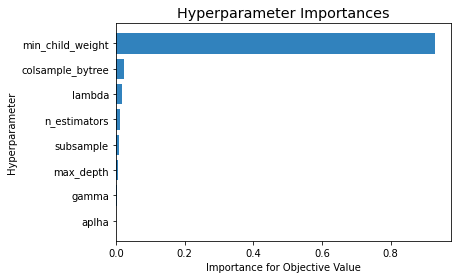

In [304]:
optuna.visualization.matplotlib.plot_param_importances(study)

# XGBRegressor Submission

In [307]:
submission = pd.read_csv('./input/sample_submission.csv')
submission.head()

,id,target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [308]:
submission['target'] = xgb_model_pred

In [309]:
submission

,id,target
0,1,344381.812500
1,2,131927.562500
2,3,181320.640625
3,4,250573.531250
4,5,126170.164062
...,...,...
1345,1346,313773.875000
1346,1347,131441.593750
1347,1348,78751.773438
1348,1349,226922.109375


In [313]:
submission.shape

(1350, 2)

In [312]:
submission.to_csv('submission.csv', index=False)